# **Elliptic++ Actors (Wallet Addresses) Dataset**

***Note: "Actor" refers to a Bitcoin wallet address***

---
---


Released by: Youssef Elmougy, Ling Liu



School of Computer Science, Georgia Institute of Technology

Contact: yelmougy3@gatech.edu


---

Github Repository: [https://www.github.com/git-disl/EllipticPlusPlus](https://www.github.com/git-disl/EllipticPlusPlus)


If you use our dataset in your work, please cite our paper:





>> Youssef Elmougy and Ling Liu. 2023. Demystifying Fraudulent Transactions and Illicit Nodes in the Bitcoin Network for Financial Forensics.

---



## [SETUP] Import libraries and csv files 

Download dataset from: [https://www.github.com/git-disl/EllipticPlusPlus](https://www.github.com/git-disl/EllipticPlusPlus)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp drive/My\ Drive/Elliptic++\ Dataset/wallets_features.csv ./
!cp drive/My\ Drive/Elliptic++\ Dataset/wallets_classes.csv ./
!cp drive/My\ Drive/Elliptic++\ Dataset/AddrAddr_edgelist.csv ./
!cp drive/My\ Drive/Elliptic++\ Dataset/AddrTx_edgelist.csv ./
!cp drive/My\ Drive/Elliptic++\ Dataset/TxAddr_edgelist.csv ./
!cp drive/My\ Drive/Elliptic++\ Dataset/wallets_features_classes_combined.csv ./

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.graph_objs as go 
import plotly.offline as py 
import math
from collections import Counter

!pip install -U ipython 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone 

import xgboost as xgb

In [ ]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 17.7 MB/s eta 0:00:00
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=4ad64e3b8b283172c1ae01f750cdea27fcc42eeef533a5a0428c77fa474f08d2
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 requires jinja2<=3.0.0, but you have jinja2 3.1.2 which is incompatib

## Actors Dataset Overview


---

This section loads the 5 csv files (wallets_features, wallets_classes, AddrAddr_edgelist, AddrTx_edgelist, TxAddr_edgelist) and provides a quick overview of the dataset structure and features.

Load saved actors dataset csv files:

In [ ]:
print("\nActors features: \n")
df_wallets_features = pd.read_csv("wallets_features.csv")
df_wallets_features

print("\nActors Classes: \n")
df_wallets_classes = pd.read_csv("wallets_classes.csv")
df_wallets_classes

print("\nAddress-Address edgelist: \n") #Actor Interaction graph edgelist
df_AddrAddr_edgelist = pd.read_csv("AddrAddr_edgelist.csv")
df_AddrAddr_edgelist

print("\nAddress-Transaction edgelist: \n") #Address-Transaction graph edgelist
df_AddrTx_edgelist = pd.read_csv("AddrTx_edgelist.csv")
df_AddrTx_edgelist

print("\nTransaction-Address edgelist: \n") #Address-Transaction graph edgelist
df_TxAddr_edgelist = pd.read_csv("TxAddr_edgelist.csv")
df_TxAddr_edgelist

# combined features and classes csv files for convenience
df_wallets_features_classes_combined = pd.read_csv("wallets_features_classes_combined.csv")


Actors features: 



,address,Time step,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,first_received_block,...,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median
0,111112TykSw72ztDN2WJger4cynzWYC5w,25,0.0,1.0,439586.0,439586.0,0.0,1.0,0.0,439586.0,...,0.0,0.0,0.000000,0.0,0.0,24.0,1.0,1.0,1.0,1.0
1,1111DAYXhoxZx2tsRnzimfozo783x1yC2,25,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,439589.0,...,0.0,20164.0,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0
2,1111DAYXhoxZx2tsRnzimfozo783x1yC2,29,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,439589.0,...,0.0,20164.0,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0
3,1111DAYXhoxZx2tsRnzimfozo783x1yC2,39,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,439589.0,...,0.0,20164.0,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0
4,1111DAYXhoxZx2tsRnzimfozo783x1yC2,39,0.0,8.0,439589.0,485959.0,46370.0,8.0,0.0,439589.0,...,0.0,20164.0,6624.285714,8060.0,0.0,8.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268255,3R2Uw5MRdSSigp8AjfT7K5es6Hupm4qLSq,31,1.0,1.0,451684.0,451685.0,1.0,2.0,451685.0,451684.0,...,0.0,0.0,0.000000,0.0,0.0,3.0,1.0,1.0,1.0,1.0
1268256,3R2VBFbqHGC4bQ7b4ixN4jZTdv7RMbEYtf,44,0.0,1.0,477895.0,477895.0,0.0,1.0,0.0,477895.0,...,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1268257,3R2WFmRwbDeo3rMVVu5J3jjMxAuQYYWAid,9,0.0,1.0,407342.0,407342.0,0.0,1.0,0.0,407342.0,...,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1268258,3R2WTZGYLmbJQyoDSBftJsPRvF1mSEtkh6,3,0.0,1.0,395235.0,395235.0,0.0,1.0,0.0,395235.0,...,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0



Actors Classes: 



,address,class
0,111112TykSw72ztDN2WJger4cynzWYC5w,2
1,1111DAYXhoxZx2tsRnzimfozo783x1yC2,3
2,1111VHuXEzHaRCgXbVwojtaP7Co3QABb,2
3,111218KKkh1JJFRHbwM16AwCiVCc4m7he1,3
4,1115LWW3xsD9jT9VRY7viCN9S34RVAAuA,2
...,...,...
822937,3R2Uw5MRdSSigp8AjfT7K5es6Hupm4qLSq,3
822938,3R2VBFbqHGC4bQ7b4ixN4jZTdv7RMbEYtf,3
822939,3R2WFmRwbDeo3rMVVu5J3jjMxAuQYYWAid,3
822940,3R2WTZGYLmbJQyoDSBftJsPRvF1mSEtkh6,3



Address-Address edgelist: 



,input_address,output_address
0,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a,1GASxu5nMntiRKdVtTVRvEbP965G51bhHH
1,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a
2,13Lhad3SAmu2vqYg2dxbNcxH7LE77kJu2w,1GFdrdgtG34GChM8SMpMwcXFc4nYbH1A5G
3,1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz,19q57SeCEzTnWrWVXA43nZzhSiXkYggh7c
4,1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz,1Kk1NVYnCE8ALXDhgMM6HqTt1jDSvi6QBA
...,...,...
2868959,3MfN5to5K5be2RupWE8rjJHQ6V9L8ypWeh,3MfN5to5K5be2RupWE8rjJHQ6V9L8ypWeh
2868960,3DzbpEogZ1mn9FgCHcmzYPLDbV9GuxYHpi,38jMiiZs2C5n5MPkyc5pSA7wwW6H4p6hPa
2868961,34yD1sQg6C16aANCtibYXRj5NsX6tt4v5R,3G9b7hWZccuft1V4eGUcZqTZaxsqx699bM
2868962,1JERHCgwHG2Z7T3KjNpEwj3fJNX8vSfCX2,1JERHCgwHG2Z7T3KjNpEwj3fJNX8vSfCX2



Address-Transaction edgelist: 



,input_address,txId
0,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a,230325127
1,13Lhad3SAmu2vqYg2dxbNcxH7LE77kJu2w,230325139
2,1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz,86875675
3,16zs5SVSyADh5WrLNbZbpRLsBsN5uEzgeK,230325147
4,1QJpwtUorBKPGUJkSyrRcBKTAHq4CXrdYh,230325154
...,...,...
477112,1HdnGvuc21Y4QfBEHUc3NFRJhGywdSFUb,157659046
477113,3MfN5to5K5be2RupWE8rjJHQ6V9L8ypWeh,157659306
477114,3DzbpEogZ1mn9FgCHcmzYPLDbV9GuxYHpi,157668825
477115,34yD1sQg6C16aANCtibYXRj5NsX6tt4v5R,125788182



Transaction-Address edgelist: 



,txId,output_address
0,230325127,1GASxu5nMntiRKdVtTVRvEbP965G51bhHH
1,230325127,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a
2,230325139,1GFdrdgtG34GChM8SMpMwcXFc4nYbH1A5G
3,86875675,19q57SeCEzTnWrWVXA43nZzhSiXkYggh7c
4,86875675,1Kk1NVYnCE8ALXDhgMM6HqTt1jDSvi6QBA
...,...,...
837119,157659306,3MfN5to5K5be2RupWE8rjJHQ6V9L8ypWeh
837120,157668825,38jMiiZs2C5n5MPkyc5pSA7wwW6H4p6hPa
837121,125788182,3G9b7hWZccuft1V4eGUcZqTZaxsqx699bM
837122,157670868,1JERHCgwHG2Z7T3KjNpEwj3fJNX8vSfCX2


Data structure for an example actor (address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K):

In [ ]:
print("\nwallets_features.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K\n")
df_wallets_features[df_wallets_features['address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K']

print("\nwallets_classes.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K\n")
df_wallets_classes[df_wallets_classes['address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K']

print("\nAddrAddr_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0\n")
df_AddrAddr_edgelist[(df_AddrAddr_edgelist['input_address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K') | (df_AddrAddr_edgelist['output_address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K')]

print("\nAddrTx_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0\n")
df_AddrTx_edgelist[df_AddrTx_edgelist['input_address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K']

print("\nTxAddr_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0\n")
df_TxAddr_edgelist[df_TxAddr_edgelist['output_address']=='39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K']


wallets_features.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K



,address,Time step,num_txs_as_sender,num_txs_as receiver,first_block_appeared_in,last_block_appeared_in,lifetime_in_blocks,total_txs,first_sent_block,first_received_block,...,blocks_btwn_output_txs_min,blocks_btwn_output_txs_max,blocks_btwn_output_txs_mean,blocks_btwn_output_txs_median,num_addr_transacted_multiple,transacted_w_address_total,transacted_w_address_min,transacted_w_address_max,transacted_w_address_mean,transacted_w_address_median
1149250,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,23,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
1149251,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,23,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
1149252,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,23,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
1149253,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,23,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
1149254,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,24,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149666,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,32,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
1149667,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,32,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
1149668,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,32,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0
1149669,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,32,420.0,1.0,435559.0,453704.0,18145.0,421.0,435559.0,451682.0,...,0.0,0.0,0.0,0.0,17.0,495.0,1.0,3.0,1.046512,1.0



wallets_classes.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K



,address,class
745591,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,1



AddrAddr_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0



,input_address,output_address
1317522,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,131fHSzsK1eQJp7bC94JVWZqJ2JcdR5UfS
1317523,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
1317634,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,1FCw4XNAP6xeWMF4o3RaNENguE9qFumgpn
1317635,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
1317644,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
...,...,...
1592119,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
1592120,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
1592121,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,32ZkfqSGoxdx5UGo8YQp1tFhSv8R982Usk
1592122,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K



AddrTx_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0



,input_address,txId
235194,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,291338524
235250,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,88250674
235255,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,331553508
235256,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,331553509
239085,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,289228146
...,...,...
298647,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,355110135
298648,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,355110139
298649,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,343635736
298650,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K,355110144



TxAddr_edgelist.csv for address = 39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K0



,txId,output_address
431088,291338524,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
431200,88250674,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
431209,331553508,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
431212,331553509,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
436269,289228146,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
...,...,...
539069,355110135,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
539071,355110139,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
539073,343635736,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K
539074,355110144,39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K



Actors features --- class, 28 transaction-related features, 27 time-related features:

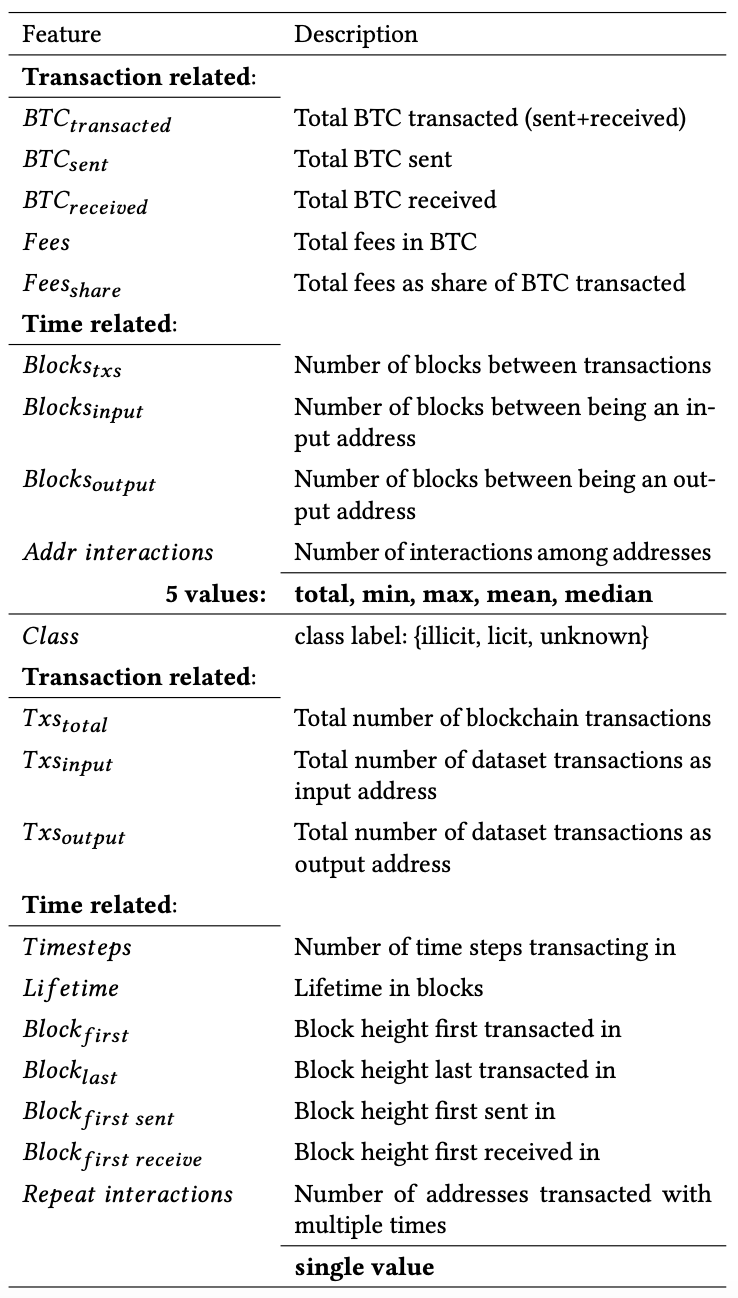


In [ ]:
df_wallets_features.columns

Index(['address', 'Time step', 'num_txs_as_sender', 'num_txs_as receiver',
       'first_block_appeared_in', 'last_block_appeared_in',
       'lifetime_in_blocks', 'total_txs', 'first_sent_block',
       'first_received_block', 'num_timesteps_appeared_in',
       'btc_transacted_total', 'btc_transacted_min', 'btc_transacted_max',
       'btc_transacted_mean', 'btc_transacted_median', 'btc_sent_total',
       'btc_sent_min', 'btc_sent_max', 'btc_sent_mean', 'btc_sent_median',
       'btc_received_total', 'btc_received_min', 'btc_received_max',
       'btc_received_mean', 'btc_received_median', 'fees_total', 'fees_min',
       'fees_max', 'fees_mean', 'fees_median', 'fees_as_share_total',
       'fees_as_share_min', 'fees_as_share_max', 'fees_as_share_mean',
       'fees_as_share_median', 'blocks_btwn_txs_total', 'blocks_btwn_txs_min',
       'blocks_btwn_txs_max', 'blocks_btwn_txs_mean', 'blocks_btwn_txs_median',
       'blocks_btwn_input_txs_total', 'blocks_btwn_input_txs_min',
       

## Feature Analysis


---

This section analyzes features using scikit learn feature importances, permutation feature importance, and drop column feature importance.

RF.feature_importances_:

In [ ]:
imp_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Imp": cRF.feature_importances_
})
imp_df.sort_values(by="Imp", ascending=False)
imp_df_sorted = imp_df.sort_values(by="Imp", ascending=False)
imp_df_sorted

,Feature,Imp
50,transacted_w_address_total,0.097278
6,first_sent_block,0.064506
28,fees_median,0.054235
26,fees_max,0.053693
27,fees_mean,0.053543
3,last_block_appeared_in,0.051993
2,first_block_appeared_in,0.050069
25,fees_min,0.049734
24,fees_total,0.046314
7,first_received_block,0.038914


Top 20 and Bottom 20 features:

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

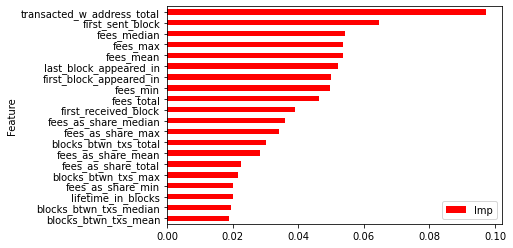

In [ ]:
# top 20 features
plt.figure(figsize=(10,10))
imp_df_sorted[:20].iloc[::-1].plot(kind='barh',y='Imp',x='Feature',color='r')

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

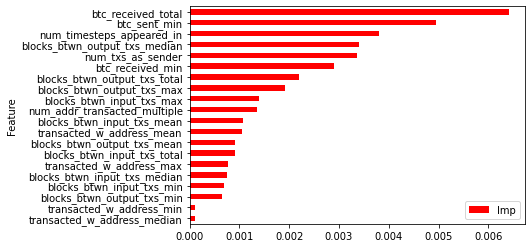

In [ ]:
# bottom 20 features
plt.figure(figsize=(10,10))
imp_df_sorted[35:].iloc[::-1].plot(kind='barh',y='Imp',x='Feature',color='r')

Permutation feature importance:

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(cRF, random_state=1).fit(X_train.values, y_train.values)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.0165 ± 0.0005,transacted_w_address_total
0.0138 ± 0.0005,first_sent_block
0.0071 ± 0.0004,fees_min
0.0058 ± 0.0001,first_received_block
0.0053 ± 0.0002,fees_max
0.0051 ± 0.0002,fees_as_share_max
0.0045 ± 0.0001,first_block_appeared_in
0.0041 ± 0.0001,fees_as_share_median
0.0037 ± 0.0001,last_block_appeared_in
0.0029 ± 0.0001,fees_as_share_min


Drop column feature importance:

In [ ]:
model = cRF
random_state = 42

# clone the model to have the exact same specification as the one initially trained
model_clone = clone(model)
# set random_state for comparability
model_clone.random_state = random_state
# training and scoring the benchmark model
model_clone.fit(X_train.values, y_train.values)
benchmark_score = model_clone.score(X_train.values, y_train.values)
# list for storing feature importances
importances = []

# iterating over all columns and storing feature importance (difference between benchmark and new model)
for col in X_train.columns:
    model_clone = clone(model)
    model_clone.random_state = random_state
    model_clone.fit(X_train.drop(col, axis = 1).values, y_train.values)
    drop_col_score = model_clone.score(X_train.drop(col, axis = 1).values, y_train.values)
    importances.append(benchmark_score - drop_col_score)

importances_df = pd.DataFrame (X_train.columns, importances)
get_drop_importance = importances_df

In [ ]:
get_drop_importance.reset_index(inplace=True)
get_drop_importance = get_drop_importance.rename(columns = {'index':'Imp', 0:'Feature'})
get_drop_importance = get_drop_importance.sort_values('Imp', ascending=False)
get_drop_importance

,Imp,Feature
0,-0.000032,num_txs_as_sender
1,-0.000032,num_txs_as receiver
2,-0.000016,first_block_appeared_in
3,0.000005,last_block_appeared_in
4,-0.000027,lifetime_in_blocks
5,-0.000038,total_txs
6,0.000043,first_sent_block
7,0.000000,first_received_block
8,-0.000038,num_timesteps_appeared_in
9,-0.000027,btc_transacted_total


## RF Trees Analysis


---

This section explores the voting of all 50 RF trees for actors in the testing set.

Analysis on RF tree voting can show the effect of increased classification accuracy after selecting important features. Refer to the paper to see the before and after effects of selecting features on the RF tree voting (Figure 12b).

Visualizing the features making up each of the 50 RF trees (there are many trees as we don't set a limit of number of features per tree, but for easier analysis the number of features per tree can be limited):

In [ ]:
n=0
while n < 50:
    classes = ['0','1']
    fig = plt.figure(figsize=(50, 50))
    plot_tree(cRF.estimators_[n], class_names=classes, filled=True, impurity=True, rounded=True)
    n+=1

Look at individual RF tree votes for an actor. Change the "sample_id" below for the index of the actor in the testing set:

In [ ]:
estimator = cRF

n_nodes_ = [t.tree_.node_count for t in estimator.estimators_]
children_left_ = [t.tree_.children_left for t in estimator.estimators_]
children_right_ = [t.tree_.children_right for t in estimator.estimators_]
feature_ = [t.tree_.feature for t in estimator.estimators_]
threshold_ = [t.tree_.threshold for t in estimator.estimators_]


def explore_tree(estimator, n_nodes, children_left,children_right, feature,threshold,
                suffix='', print_tree= False, sample_id=0, feature_names=None):

    if not feature_names:
        feature_names = feature

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)

    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    # First let's retrieve the decision path of each sample. The decision_path
    # method allows to retrieve the node indicator functions. A non zero element of
    # indicator matrix at the position (i, j) indicates that the sample i goes
    # through the node j.

    node_indicator = estimator.decision_path(X_test.values)

    # Similarly, we can also have the leaves ids reached by each sample.

    leave_id = estimator.apply(X_test.values)

    # Now, it's possible to get the tests that were used to predict a sample or
    # a group of samples. First, let's make it for the sample.

    node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                        node_indicator.indptr[sample_id + 1]]

    for node_id in node_index:
        tabulation = ""

        if (X_test.values[sample_id, feature[node_id]] <= threshold[node_id]):
            threshold_sign = "<="
        else:
            threshold_sign = ">"

    print("%sPrediction for sample %d: %s"%(tabulation,
                                          sample_id,
                                          estimator.predict(X_test.values)[sample_id]))

    # For a group of samples, we have the following common node.
    sample_ids = [sample_id, 1]
    common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                    len(sample_ids))

    common_node_id = np.arange(n_nodes)[common_nodes]

    for sample_id_ in sample_ids:
        print("Prediction for sample %d: %s"%(sample_id_,
                                          estimator.predict(X_test.values)[sample_id_]))
        
for i,e in enumerate(estimator.estimators_):

    print("Tree %d\n"%i)
    explore_tree(estimator.estimators_[i],n_nodes_[i],children_left_[i],
                 children_right_[i], feature_[i],threshold_[i],
                suffix=i, sample_id=11983, feature_names=list(X_train.columns)[2:])
    print('\n'*2)

# **Acknowledgements**


---
---


Released by: Youssef Elmougy, Ling Liu



School of Computer Science, Georgia Institute of Technology

Contact: yelmougy3@gatech.edu


---

Github Repository: [https://www.github.com/git-disl/EllipticPlusPlus](https://www.github.com/git-disl/EllipticPlusPlus)


If you use our dataset in your work, please cite our paper:





>> Youssef Elmougy and Ling Liu. 2023. Demystifying Fraudulent Transactions and Illicit Nodes in the Bitcoin Network for Financial Forensics.

---

